In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

In [523]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 6)
pd.set_option('display.precision', 1)

## Read in data

In [524]:
colnames = list(pd.read_csv('data/colnames.csv', header=None).loc[:,0])

df_raw = pd.read_csv('data/ICOWdyadyr.csv', header=0, names=colnames, low_memory=False)
df_raw.sample(10)

,issue,terriss,riveriss,mariss,region,claimdy,claim,dyadnum,chal,tgt,dyad,year,icowsal,icowsalc,salchal,saltgt,salold,saltan,salint,salintc,salintt,tchomechal,tchometgt,tcpop,tcresource,tcstratloc,tcidenchal,tcidentgt,tchistchal,tchisttgt,tcoffshore,tccontchal,tcconttgt,tcncontig,tcentirecl,tcarea,tclnarea,rcquantcl,rcqualcl,rcnavcl,rcrivtype,rchomechal,rchometgt,rcnavc,rcnavt,rcpopc,rcpopt,rcresourcc,rcresourct,rcpowerc,rcpowert,rcirrigc,rcirrigt,rcdamsc,rcdamst,rcterrclm,rcterrnum,mchomechal,mchometgt,mcresource,mcstratloc,mcfishing,mcmigrate,mcoil,mcoffshore,mcterrclm,mcterrnum,nbilat,attbilat,n3non,att3non,n3bind,att3bind,att3rd,nmidiss,midissyr,maxhost,maxfatal,nfatal,midfatyr,nwar,waryr,attemptsp,attemptst,attanyp,attanyt,attmult,attnone,recmid5,recmid10,recmid15,recmidwt,recfat5,recfat10,recfat15,recfatwt,recwar5,recwar10,recwar15,recwarwt,recno5,recno10,recno15,recnowt,recyes5,recyes10,recyes15,recyeswt,pacsett,tergen,terviol,tertot,version
1223,1,1,0,0,1,6001,60,1,70,220,70220.0,1915,4.0,1,2.0,2.0,3.0,2,2,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,2,2,0.7,1.0,0.0,0.0,0.0,1.1
3063,1,1,0,0,1,12201,122,1,140,200,140200.0,1925,2.0,1,2.0,0.0,3.0,0,2,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,13000.0,9.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,2.0,0.0,1.0,1.0,1.1
2930,1,1,0,0,1,12001,120,1,210,200,200210.0,1958,4.0,1,2.0,2.0,4.0,2,2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.2,0,0,0,0.0,5.0,0.0,1.0,1.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,1,1,0,0,1,12003,120,3,115,110,110115.0,1990,6.0,2,3.0,3.0,6.0,2,4,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,1,3,1.0,2.0,1.0,1.0,2.0,1.1
6320,2,0,1,0,1,111501,1115,1,160,165,160165.0,1926,9.0,3,4.0,5.0,9.5,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,3.1,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,2,0.0,0,0,0,0.0,2.0,0.0,1.0,1.0,1.1
394,1,1,0,0,1,2201,22,1,70,2,2070.0,1970,4.0,1,2.0,2.0,4.0,0,4,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,21.0,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.3,11.0,0.0,4.0,4.0,1.1


In [525]:
df_raw.groupby('claim').issue.count().sort_values(ascending=False).head()

claim
2048    272
154     261
56      224
136     198
120     188
Name: issue, dtype: int64

In [526]:
df_raw[df_raw.claim == 120].sort_values('year')
#df_raw[df_raw.claim == 56].sort_values('year').attanyp

,issue,terriss,riveriss,mariss,region,claimdy,claim,dyadnum,chal,tgt,dyad,year,icowsal,icowsalc,salchal,saltgt,salold,saltan,salint,salintc,salintt,tchomechal,tchometgt,tcpop,tcresource,tcstratloc,tcidenchal,tcidentgt,tchistchal,tchisttgt,tcoffshore,tccontchal,tcconttgt,tcncontig,tcentirecl,tcarea,tclnarea,rcquantcl,rcqualcl,rcnavcl,rcrivtype,rchomechal,rchometgt,rcnavc,rcnavt,rcpopc,rcpopt,rcresourcc,rcresourct,rcpowerc,rcpowert,rcirrigc,rcirrigt,rcdamsc,rcdamst,rcterrclm,rcterrnum,mchomechal,mchometgt,mcresource,mcstratloc,mcfishing,mcmigrate,mcoil,mcoffshore,mcterrclm,mcterrnum,nbilat,attbilat,n3non,att3non,n3bind,att3bind,att3rd,nmidiss,midissyr,maxhost,maxfatal,nfatal,midfatyr,nwar,waryr,attemptsp,attemptst,attanyp,attanyt,attmult,attnone,recmid5,recmid10,recmid15,recmidwt,recfat5,recfat10,recfat15,recfatwt,recwar5,recwar10,recwar15,recwarwt,recno5,recno10,recno15,recnowt,recyes5,recyes10,recyes15,recyeswt,pacsett,tergen,terviol,tertot,version
2788,1,1,0,0,1,12001,120,1,210,200,200210.0,1816,2.0,1,1.0,1.0,2.0,0,2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.1
2789,1,1,0,0,1,12001,120,1,210,200,200210.0,1817,2.0,1,1.0,1.0,2.0,0,2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.1
2790,1,1,0,0,1,12001,120,1,210,200,200210.0,1818,2.0,1,1.0,1.0,2.0,0,2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,1,1,0,0,1,12003,120,3,115,110,110115.0,1999,6.0,2,3.0,3.0,6.0,2,4,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.6,2,3,4,2.4,5.0,2.0,2.0,4.0,1.1
2974,1,1,0,0,1,12003,120,3,115,110,110115.0,2000,6.0,2,3.0,3.0,6.0,2,4,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,2,2,1,1,1,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.5,2,3,4,2.0,5.0,2.0,2.0,4.0,1.1
2975,1,1,0,0,1,12003,120,3,115,110,110115.0,2001,6.0,2,3.0,3.0,6.0,2,4,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,17000.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,2,3,3,2.4,2,2,4,1.7,5.0,2.0,2.0,4.0,1.1


In [527]:
df_raw.dyad.value_counts(dropna=False).sort_index()

2020.0      450
2031.0       40
2040.0       59
           ... 
660666.0     15
663666.0     58
NaN          24
Name: dyad, Length: 192, dtype: int64

In [528]:
df_raw[df_raw.dyad.isna()]

,issue,terriss,riveriss,mariss,region,claimdy,claim,dyadnum,chal,tgt,dyad,year,icowsal,icowsalc,salchal,saltgt,salold,saltan,salint,salintc,salintt,tchomechal,tchometgt,tcpop,tcresource,tcstratloc,tcidenchal,tcidentgt,tchistchal,tchisttgt,tcoffshore,tccontchal,tcconttgt,tcncontig,tcentirecl,tcarea,tclnarea,rcquantcl,rcqualcl,rcnavcl,rcrivtype,rchomechal,rchometgt,rcnavc,rcnavt,rcpopc,rcpopt,rcresourcc,rcresourct,rcpowerc,rcpowert,rcirrigc,rcirrigt,rcdamsc,rcdamst,rcterrclm,rcterrnum,mchomechal,mchometgt,mcresource,mcstratloc,mcfishing,mcmigrate,mcoil,mcoffshore,mcterrclm,mcterrnum,nbilat,attbilat,n3non,att3non,n3bind,att3bind,att3rd,nmidiss,midissyr,maxhost,maxfatal,nfatal,midfatyr,nwar,waryr,attemptsp,attemptst,attanyp,attanyt,attmult,attnone,recmid5,recmid10,recmid15,recmidwt,recfat5,recfat10,recfat15,recfatwt,recwar5,recwar10,recwar15,recwarwt,recno5,recno10,recno15,recnowt,recyes5,recyes10,recyes15,recyeswt,pacsett,tergen,terviol,tertot,version
7495,3,0,0,1,1,203402,2034,2,2220,20,NaN,1994,7.0,2,3.0,4.0,5.0,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,NaN,NaN,NaN,NaN,1.1
7496,3,0,0,1,1,203402,2034,2,2220,20,NaN,1995,7.0,2,3.0,4.0,5.0,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,NaN,NaN,NaN,NaN,1.1
9184,3,0,0,1,2,220201,2202,1,2220,200,NaN,1973,6.0,2,3.0,3.0,6.0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,NaN,NaN,NaN,NaN,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9384,3,0,0,1,2,222002,2220,2,230,2220,NaN,1982,10.0,3,5.0,5.0,8.0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,1,1,0.6,NaN,NaN,NaN,NaN,1.1
9385,3,0,0,1,2,222002,2220,2,230,2220,NaN,1983,10.0,3,5.0,5.0,8.0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.5,NaN,NaN,NaN,NaN,1.1
9386,3,0,0,1,2,222002,2220,2,230,2220,NaN,1984,10.0,3,5.0,5.0,8.0,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,1,0.4,NaN,NaN,NaN,NaN,1.1


## Remove irrelevant and extraneous columns

In [542]:
# conflict-type-specific columns
df = df_raw[df_raw.dyad.notnull()]
df = df.dropna(axis=1)

# ~metadata columns
#dropcols = 'issue claimdy claim dyadnum chal tgt version'.split()
dropcols = 'issue claimdy claim dyadnum chal tgt version'.split()

# columns that are linearly dependent on target
dropcols.append('attemptsp')
dropcols.append('attemptst')
dropcols.append('attnone')
dropcols.append('nbilat')
dropcols.append('attbilat')
dropcols.append('attanyt')
dropcols.append('icowsalc')
dropcols.append('n3non')
dropcols.append('att3non')
dropcols.append('att3rd')
dropcols.append('attmult')

df = df.drop(dropcols, axis=1)

# REMOVE:
#  issue
#  claimdy
#  claim
#  dyadnum
#  chal
#  tgt
#  dyad
#  version
#  ~year

## Replace categorical columns with dummy variable columns

In [543]:
# region
region_names = ['west_hemi', 'europe', 'mid_east']
region_dummies = pd.get_dummies(df.region)
region_dummies.columns = region_names
region_dummies

df = df.drop('region', axis=1)
df = pd.concat([df, region_dummies], axis=1)
df

,terriss,riveriss,mariss,dyad,year,icowsal,salchal,saltgt,salold,saltan,salint,n3bind,att3bind,nmidiss,midissyr,maxhost,maxfatal,nfatal,midfatyr,nwar,waryr,attanyp,recmid5,recmid10,recmid15,recmidwt,recfat5,recfat10,recfat15,recfatwt,recwar5,recwar10,recwar15,recwarwt,recno5,recno10,recno15,recnowt,recyes5,recyes10,recyes15,recyeswt,west_hemi,europe,mid_east
0,1,0,0,2200.0,1816,3.0,2.0,1.0,1.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,0,0
1,1,0,0,2200.0,1817,3.0,2.0,1.0,1.0,0,3,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,0,0
2,1,0,0,2200.0,1816,3.0,2.0,1.0,5.0,2,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10038,0,0,1,365385.0,1911,3.0,1.0,2.0,3.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,0
10039,0,0,1,365390.0,1911,3.0,1.0,2.0,3.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,0
10040,0,0,1,365740.0,1911,3.0,1.0,2.0,3.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,1,0


## Basic random forest MVP

In [545]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [546]:
y = df.attanyp
X = df.drop('attanyp', axis=1)

In [547]:
randseed = np.random.randint(low=1, high=100)

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=randseed)

In [548]:
# Create the model with 100 trees
rfm = RandomForestClassifier(
    n_estimators=500,
    #criterion='gini',
    #max_depth=None,
    #min_samples_split=2,
    #min_samples_leaf=1,
    #min_weight_fraction_leaf=0,
    max_features='sqrt',
    #max_leaf_nodes=None,
    #min_impurity_decrease=0,
    #min_impurity_split=1e-7,
    #bootstrap=True,
    #oob_score=False,
    #n_jobs=None,
    #random_state=None,
    #verbose=0,
    #warm_start=False,
    #class_weight=None
)

# Fit on training data
rfm.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [549]:
# train set
train_rfm_predictions = rfm.predict(X_train)
train_rfm_probs = rfm.predict_proba(X_train)[:, 1]

# test set
rfm_predictions = rfm.predict(X_test)
rfm_probs = rfm.predict_proba(X_test)[:, 1]

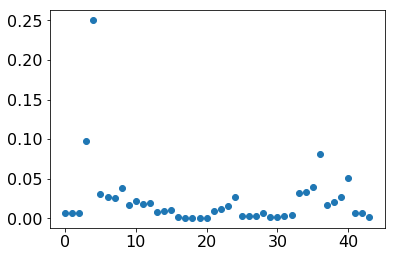

In [550]:
rfm.feature_importances_
plt.plot(rfm.feature_importances_, 'o')
#pd.DataFrame([rfm_predictions, y_test])

In [551]:
rfm.feature_importances_

array([0.0067353 , 0.00721883, 0.00678435, 0.09715185, 0.25017811,
       0.03015213, 0.02677966, 0.02535121, 0.03843608, 0.0168607 ,
       0.02203467, 0.01795416, 0.01903879, 0.0080411 , 0.00914398,
       0.01042069, 0.00131191, 0.00061669, 0.00065589, 0.00041129,
       0.00047802, 0.00954047, 0.01109846, 0.01561548, 0.02720322,
       0.00229883, 0.00255217, 0.00333711, 0.00679215, 0.00110646,
       0.00159293, 0.00230608, 0.00391391, 0.03209764, 0.03257584,
       0.03993029, 0.08068502, 0.01732168, 0.02043527, 0.02715853,
       0.05091412, 0.0069605 , 0.0069443 , 0.00186414])

In [568]:
mask = rfm.feature_importances_ >= 0.036
X.columns[mask]

Index(['dyad', 'year', 'salold', 'recno15', 'recnowt', 'recyeswt'], dtype='object')

Recall Baseline: 1.0 Test: 0.23 Train: 1.0
Precision Baseline: 0.13 Test: 0.51 Train: 1.0
Roc Baseline: 0.5 Test: 0.83 Train: 1.0


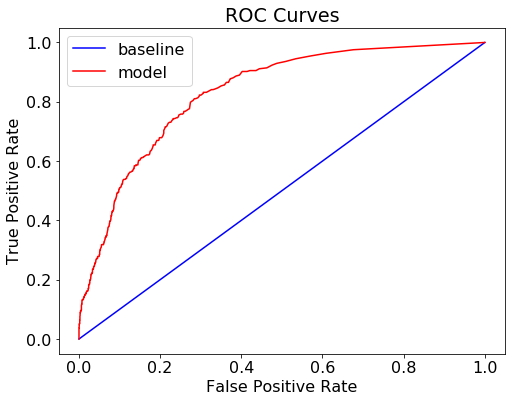

In [553]:
evaluate_model(rfm_predictions, rfm_probs, train_rfm_predictions, train_rfm_probs)

In [554]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rfm_probs)
roc_value

0.8301980045099311

In [555]:
print(classification_report(y_test, rfm_predictions))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2178
           1       0.51      0.23      0.31       327

   micro avg       0.87      0.87      0.87      2505
   macro avg       0.70      0.60      0.62      2505
weighted avg       0.84      0.87      0.85      2505



In [556]:
print(confusion_matrix(y_test, rfm_predictions))

[[2106   72]
 [ 253   74]]


## EDA pair plots

In [151]:
df_y = df['attanyp']
df_ = df.iloc[:,20:30]
df_['TARGET'] = df_y
df_.columns

Index(['attanyp', 'recmid5', 'recmid10', 'recmid15', 'recmidwt', 'recfat5',
       'recfat10', 'recfat15', 'recfatwt', 'recwar5', 'TARGET'],
      dtype='object')

In [152]:
df_

,attanyp,recmid5,recmid10,recmid15,recmidwt,recfat5,recfat10,recfat15,recfatwt,recwar5,TARGET
0,0,0,0,0,0.0,0,0,0,0.0,0,0
1,1,0,0,0,0.0,0,0,0,0.0,0,1
2,1,0,0,0,0.0,0,0,0,0.0,0,1
3,0,0,0,0,0.0,0,0,0,0.0,0,0
4,0,0,0,0,0.0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10036,0,0,0,0,0.0,0,0,0,0.0,0,0
10037,0,0,0,0,0.0,0,0,0,0.0,0,0
10038,0,0,0,0,0.0,0,0,0,0.0,0,0
10039,0,0,0,0,0.0,0,0,0,0.0,0,0


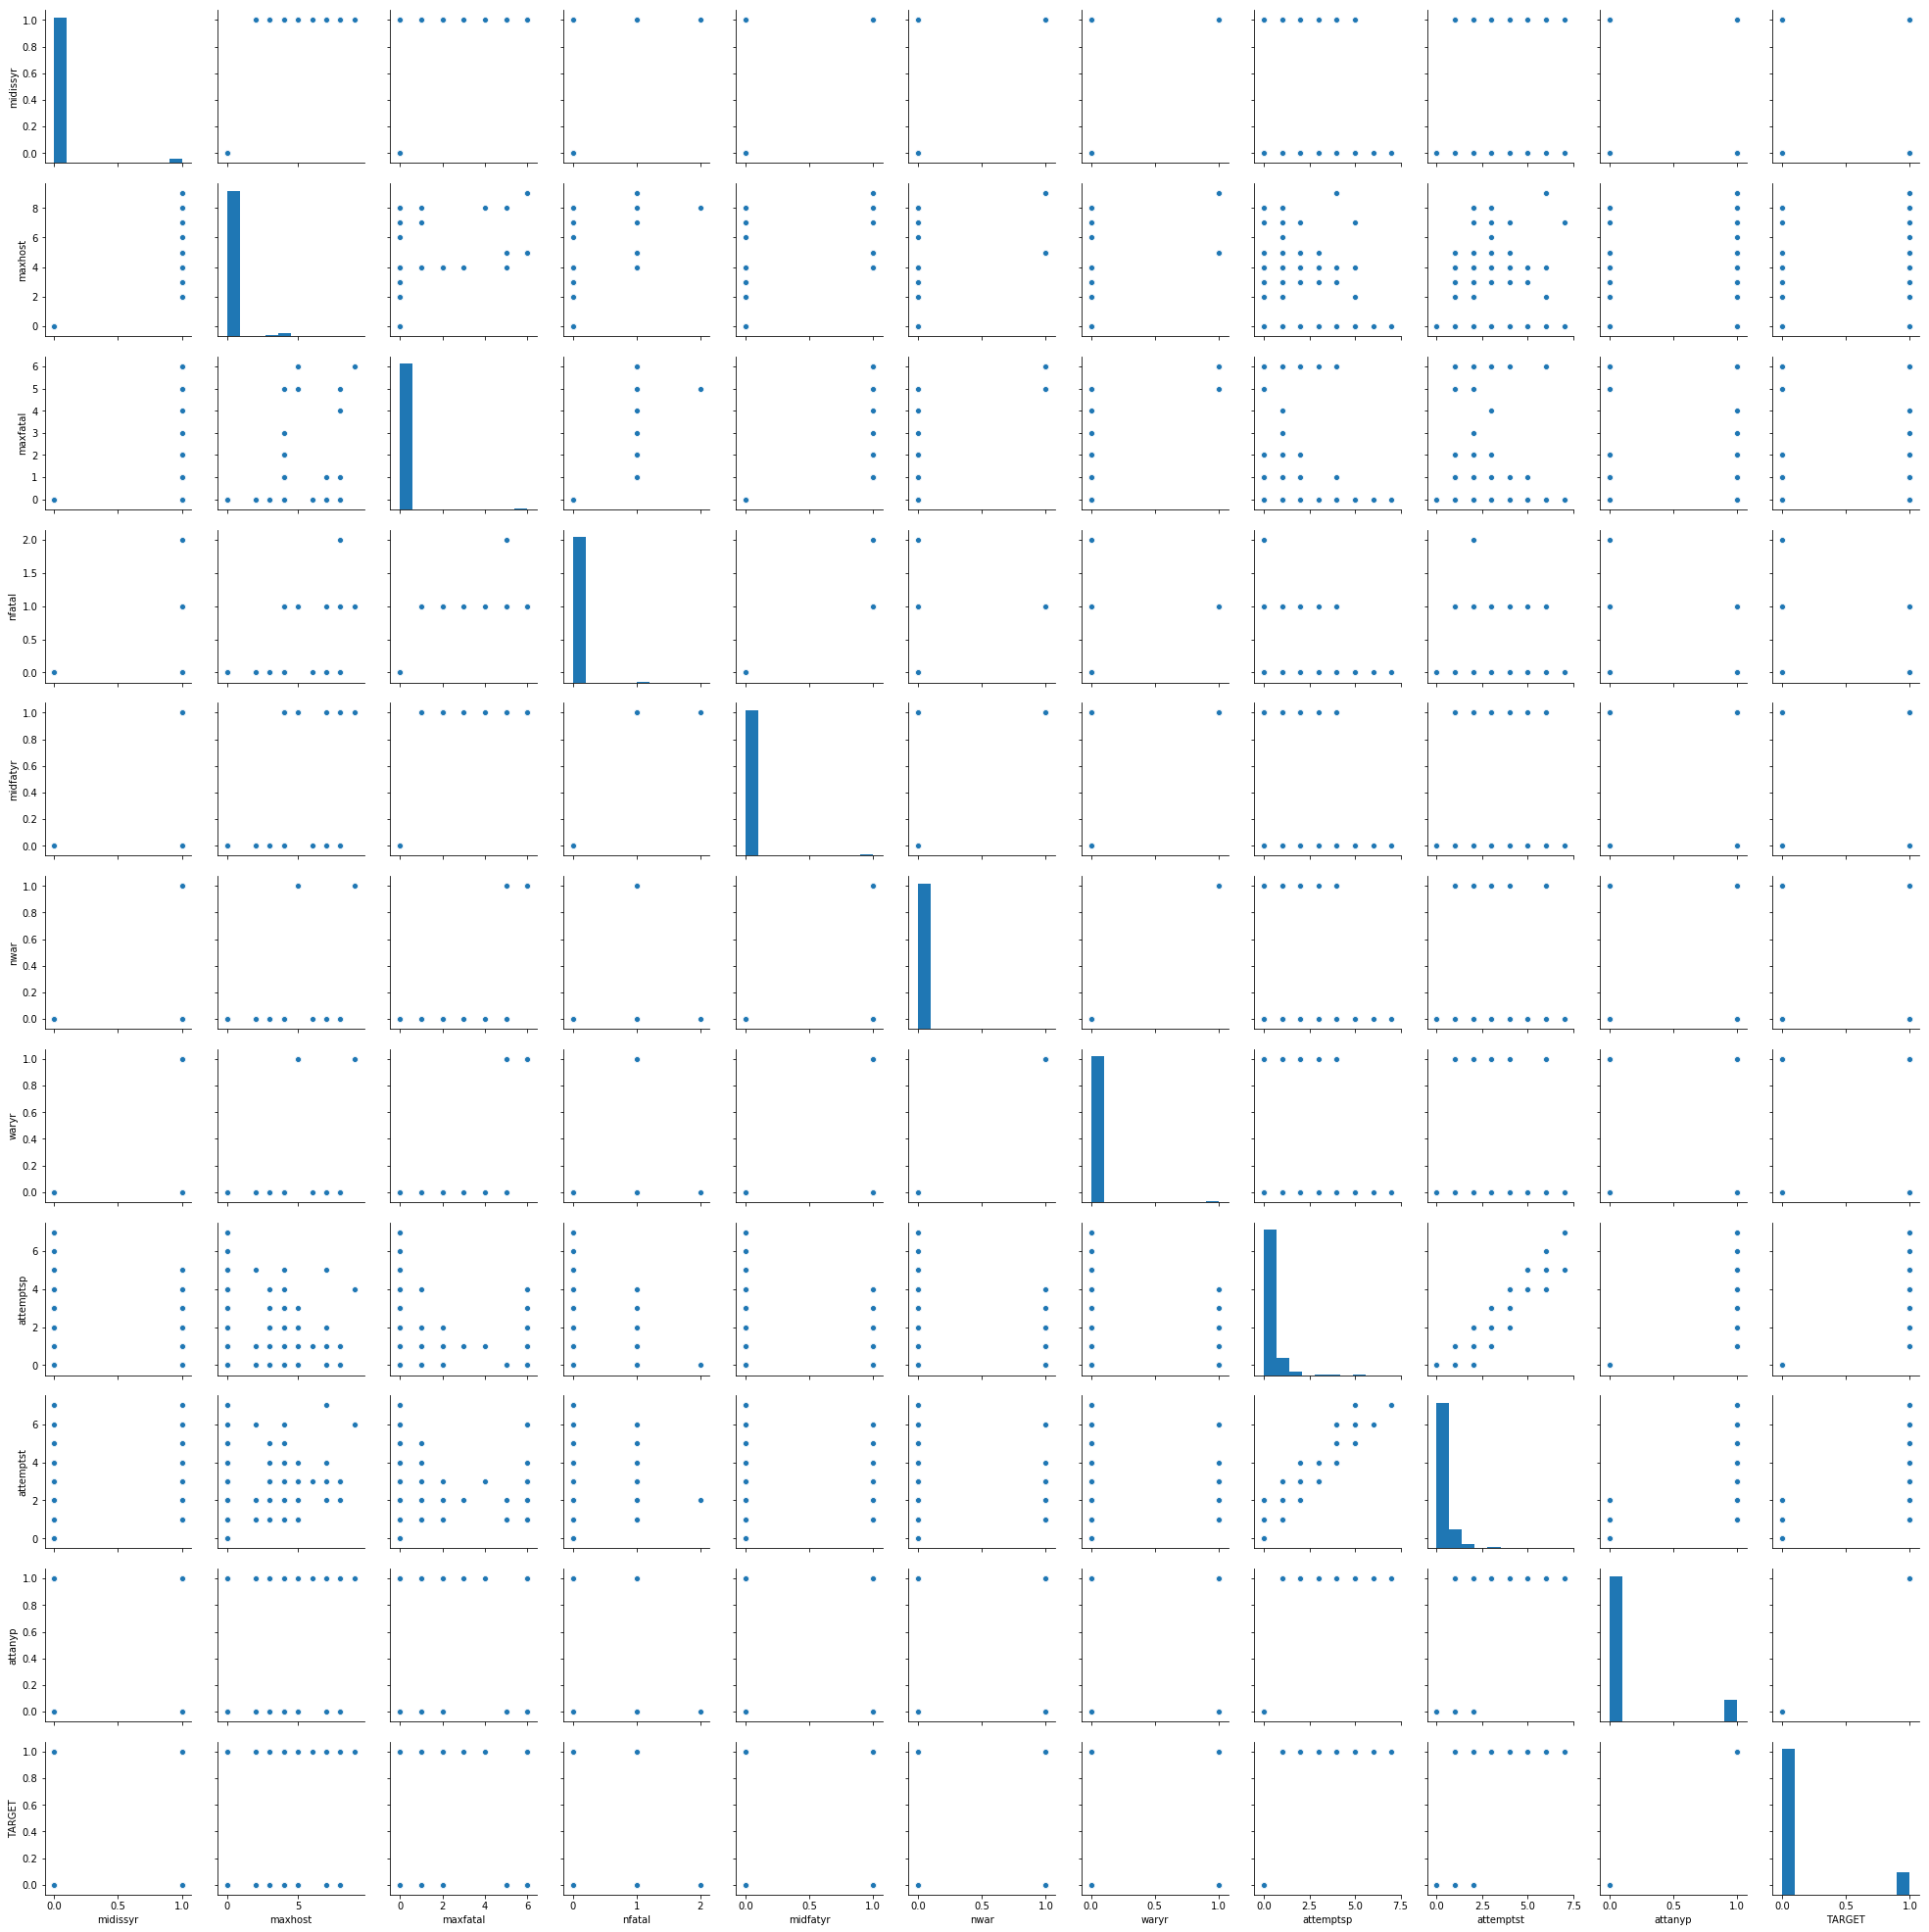

In [84]:
pairfig = sns.pairplot(data=df_)